This is the source code for the plots contained in the blog post, "[Design Considerations for a Spacecraft Solar Array](https://www.osborneee.com/spacecraft-solar-array/)."

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
from collections import namedtuple

import numpy as np
from matplotlib import pyplot as plt
from solarcell import solarcell
from worstcase import unit

solarcell.rss = 0.07

# Cell Parameter Definitions

In [3]:
# units, note the currents are per area: V, mA/cm2, mV/C, uA/cm2/C
celltype = namedtuple("celltype", "name voc jsc vmp jmp dvoc djsc dvmp djmp")

# define triple-junction solar cells
spectrolab = celltype("Spectrolab XTJ", 2.72, 18.0, 2.41, 17.5, -5.6, 10.0, -6.3, 5.0)
azurspace = celltype("Azur Space 3G30A", 2.69, 17.2, 2.41, 16.7, -6.2, 11.9, -6.7, 8.0)
solaero = celltype("Solaero ZTJ", 2.73, 17.4, 2.41, 16.5, -6.3, 11.7, -6.7, 9.1)

In [4]:
def si(name, nseries, nparallel, area, voc, isc, vmp, imp, dvoc, disc, dpmp):
    # function to derive silicon cell paramters from a panel datasheet

    area = area * 0.90 / (nseries * nparallel)  # account for solar panel packing factor
    jsc = isc / nparallel / area / 0.72  # short circuit current at AM0
    jmp = imp / nparallel / area / 0.72  # max power current at AM0
    voc = voc / nseries  # open circuit voltage
    vmp = vmp / nseries  # max power voltage

    dvoc = (voc * dvoc).to("mV/K")
    djsc = (jsc * disc).to("uA/cm^2/K")
    dpmp = (vmp * jmp * dpmp).to("uW/cm^2/K")
    djmp = djsc  # rough assumption
    dvmp = ((dpmp - vmp * djmp) / jmp).to("mV/K")

    dt = (28 - 25) * unit.K  # adjust to space standard test temperature
    voc = (voc + dvoc * dt).to("V")
    jsc = (jsc + djsc * dt).to("mA/cm^2")
    vmp = (vmp + dvmp * dt).to("V")
    jmp = (jmp + djmp * dt).to("mA/cm^2")

    return celltype(name, voc.m, jsc.m, vmp.m, jmp.m, dvoc.m, djsc.m, dvmp.m, djmp.m)

In [5]:
# define monocrystalline-silicon solar cells
bluebird = si(
    name="Bluebird Mono PERC",
    nseries=72,
    nparallel=1,
    area=1985 * unit.mm * 1000 * unit.mm,
    voc=50.0 * unit.V,
    isc=10.0 * unit.A,
    vmp=40.7 * unit.V,
    imp=9.70 * unit.A,
    dvoc=-0.300e-2 / unit.K,
    disc=+0.060e-2 / unit.K,
    dpmp=-0.370e-2 / unit.K,
)
solartech = si(
    name="SolarTech EPIQ Black",
    nseries=60,
    nparallel=1,
    area=997 * unit.mm * 1663 * unit.mm,
    voc=40.1 * unit.V,
    isc=9.50 * unit.A,
    vmp=33.6 * unit.V,
    imp=8.90 * unit.A,
    dvoc=-0.280e-2 / unit.K,
    disc=+0.043e-2 / unit.K,
    dpmp=-0.366e-2 / unit.K,
)
jasolar = si(
    name="JA Solar DeepBlue",
    nseries=54,
    nparallel=1,
    area=1722 * unit.mm * 1134 * unit.mm,
    voc=36.6 * unit.V,
    isc=13.4 * unit.A,
    vmp=30.3 * unit.V,
    imp=12.6 * unit.A,
    dvoc=-0.275e-2 / unit.K,
    disc=+0.045e-2 / unit.K,
    dpmp=-0.350e-2 / unit.K,
)

In [6]:
# for all cells, compute the efficiency and temperature coefficient
cells = (azurspace, solaero, spectrolab, solartech, bluebird, jasolar)
intensity = 1365  # W/m2
dT = 60  # affects results only a little

for cell in cells:
    pmp = cell.vmp * cell.jmp  # mW
    pin = intensity / 100**2
    eff = pmp / pin / 1000

    x = cell.vmp * cell.djmp  # uW/C
    y = cell.dvmp * cell.jmp  # uW/C
    z = cell.dvmp * cell.djmp * dT  # nW/C
    dpmp = (x + y + z / 1000) * 1e-3  # mW/C
    deff = dpmp / pin / 1000

    result = (cell.name, eff * 100, round(deff * 1e6, -1))
    print("{:24s} {:.1f}%    {:.0f}ppm/C".format(*result))

Azur Space 3G30A         29.5%    -700ppm/C
Solaero ZTJ              29.1%    -680ppm/C
Spectrolab XTJ           30.9%    -730ppm/C
SolarTech EPIQ Black     20.2%    -770ppm/C
Bluebird Mono PERC       22.2%    -870ppm/C
JA Solar DeepBlue        21.9%    -800ppm/C


# Curve Fitting

In [7]:
15 * 0.4

6.0

In [8]:
np.linspace(0.4, 6.4, 16)

array([0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8, 5.2,
       5.6, 6. , 6.4])

In [9]:
np.linspace(0, 3, 16)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. ])

In [10]:
np.linspace(-9, -18, 16)

array([ -9. ,  -9.6, -10.2, -10.8, -11.4, -12. , -12.6, -13.2, -13.8,
       -14.4, -15. , -15.6, -16.2, -16.8, -17.4, -18. ])

In [11]:
def celltype2solarcell(type, area):
    return solarcell(
        isc=(type.jsc * area / 1e3, type.djsc * area / 1e6),
        voc=(type.voc, type.dvoc / 1e3),
        imp=(type.jmp * area / 1e3, type.djmp * area / 1e6),
        vmp=(type.vmp, type.dvmp / 1e3),
        t=28,
    )

In [12]:
cell = celltype2solarcell(type=azurspace, area=30).cell(t=-60, g=1)

BRUTE:
Fit Targets: isc=0.4846, voc=3.236, imp=0.4799, vmp=3, pmp=1.439
Fit Results: isc=0.4891, voc=3.346, imp=0.454, vmp=2.933, pmp=1.331
Fit RSS: 0.06822670991278487
Fit UB:  -9.00   3.00   6.40 
Fit X0: -13.20   2.20   6.00 
Fit LB: -18.00   0.00   0.40 
POLISH:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.06822670991278487
        x: [-2.000e+00 -1.320e+01  1.000e-01  2.200e+00  6.000e+00]
      nit: 1
      jac: [-1.429e-02 -1.262e-02  5.359e-02 -6.581e-02  3.666e-02]
     nfev: 18
     njev: 3
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [13]:
cell = celltype2solarcell(type=spectrolab, area=30).cell(t=-60, g=1)

BRUTE:
Fit Targets: isc=0.5136, voc=3.213, imp=0.5118, vmp=2.964, pmp=1.517
Fit Results: isc=0.5182, voc=3.234, imp=0.4766, vmp=2.892, pmp=1.378
Fit RSS: 0.07385736196387112
Fit UB:  -9.00   4.00   6.40 
Fit X0: -17.40   2.00   4.40 
Fit LB: -18.00   1.00   0.40 
POLISH:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.07385736196387112
        x: [-2.000e+00 -1.740e+01  1.000e-01  2.000e+00  4.400e+00]
      nit: 1
      jac: [-1.813e-02  1.353e-02  5.745e-02 -1.173e-01 -4.344e-02]
     nfev: 18
     njev: 3
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [14]:
cell = celltype2solarcell(type=solartech, area=30).cell(t=28, g=1)

BRUTE:
Fit Targets: isc=1.594, voc=0.6627, imp=1.493, vmp=0.5531, pmp=0.8258
Fit Results: isc=1.608, voc=0.6444, imp=1.47, vmp=0.5391, pmp=0.7924
Fit RSS: 0.041557679281771114
Fit UB:  -9.00   1.00   6.40 
Fit X0:  -9.00   1.00   1.20 
Fit LB: -18.00  -2.00   0.40 
POLISH:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.017710981342258496
        x: [-1.852e+00 -9.074e+00  1.066e-02  1.000e+00  1.222e+00]
      nit: 13
      jac: [ 1.627e-03  3.533e-03  1.304e-03 -5.097e-02 -2.269e-04]
     nfev: 120
     njev: 20
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [15]:
cell = celltype2solarcell(type=solartech, area=120).cell(t=80, g=1)

BRUTE:
Fit Targets: isc=6.517, voc=0.5654, imp=6.115, vmp=0.4331, pmp=2.649
Fit Results: isc=6.556, voc=0.5712, imp=6.009, vmp=0.4421, pmp=2.656
Fit RSS: 0.029435638136532886
Fit UB:  -9.00   1.00   6.40 
Fit X0: -10.20   0.40   0.80 
Fit LB: -18.00  -2.00   0.40 
POLISH:
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.029435638136532886
        x: [-2.000e+00 -1.020e+01  1.000e-02  4.000e-01  8.000e-01]
      nit: 1
      jac: [-9.438e-03 -1.165e-01 -7.499e+00 -3.698e-02  1.446e+00]
     nfev: 18
     njev: 3
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


Fit Targets: isc=0.516, voc=2.69, imp=0.501, vmp=2.41, pmp=1.207
Fit Results: isc=0.5207, voc=2.714, imp=0.483, vmp=2.391, pmp=1.155
Fit RSS: 0.03895551688552673
Fit UB:  -9.00   3.00   6.40 
Fit X0: -14.89   2.03   3.05 
Fit LB: -18.00   0.00   0.40 


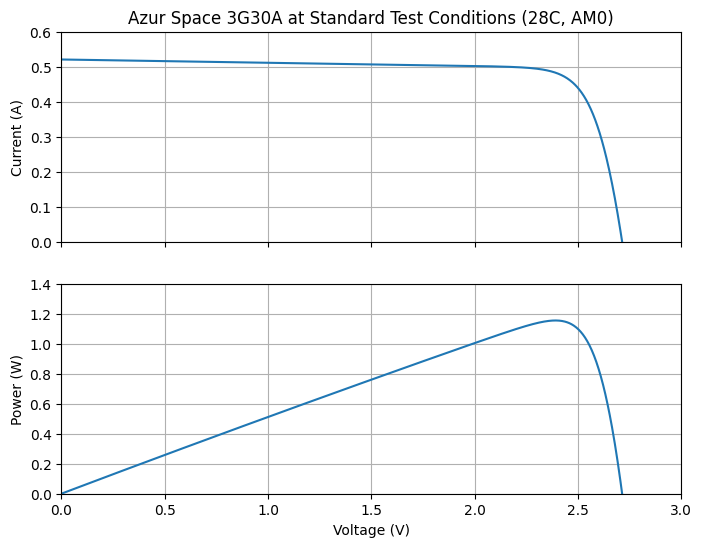

In [16]:
cell = celltype2solarcell(type=azurspace, area=30).cell(t=28, g=1)
v = np.linspace(0, cell.voc, 1000)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))
ax[0].plot(v, cell.iv(v))
ax[1].plot(v, cell.pv(v))
ax[0].set_ylabel("Current (A)")
ax[1].set_ylabel("Power (W)")
ax[1].set_xlabel("Voltage (V)")
ax[0].grid()
ax[1].grid()
ax[0].set_xlim((0, 3))
ax[0].set_ylim((0, 0.6))
ax[1].set_ylim((0, 1.4))
ax[0].set_title("Azur Space 3G30A at Standard Test Conditions (28C, AM0)")
plt.show()

SOLVING: Spectrolab XTJ -60
Fit Targets: isc=0.5136, voc=3.213, imp=0.5118, vmp=2.964, pmp=1.517
Fit Results: isc=0.5183, voc=3.264, imp=0.4793, vmp=2.919, pmp=1.399
Fit RSS: 0.0678625270313305
Fit UB:  -9.00   4.00   6.40 
Fit X0: -17.36   2.05   4.45 
Fit LB: -18.00   1.00   0.40 

SOLVING: Spectrolab XTJ 28
Fit Targets: isc=0.54, voc=2.72, imp=0.525, vmp=2.41, pmp=1.265
Fit Results: isc=0.5449, voc=2.732, imp=0.5056, vmp=2.4, pmp=1.213
Fit RSS: 0.03858038324088158
Fit UB:  -9.00   3.00   6.40 
Fit X0: -14.46   2.03   3.16 
Fit LB: -18.00   0.00   0.40 

SOLVING: Spectrolab XTJ 80
Fit Targets: isc=0.5556, voc=2.429, imp=0.5328, vmp=2.082, pmp=1.11
Fit Results: isc=0.5607, voc=2.424, imp=0.5202, vmp=2.087, pmp=1.086
Fit RSS: 0.025523092802655203
Fit UB:  -9.00   2.00   6.40 
Fit X0: -11.84   2.05   2.93 
Fit LB: -18.00  -1.00   0.40 

SOLVING: Azur Space 3G30A -60
Fit Targets: isc=0.4846, voc=3.236, imp=0.4799, vmp=3, pmp=1.439
Fit Results: isc=0.489, voc=3.295, imp=0.4526, vmp=2.943,

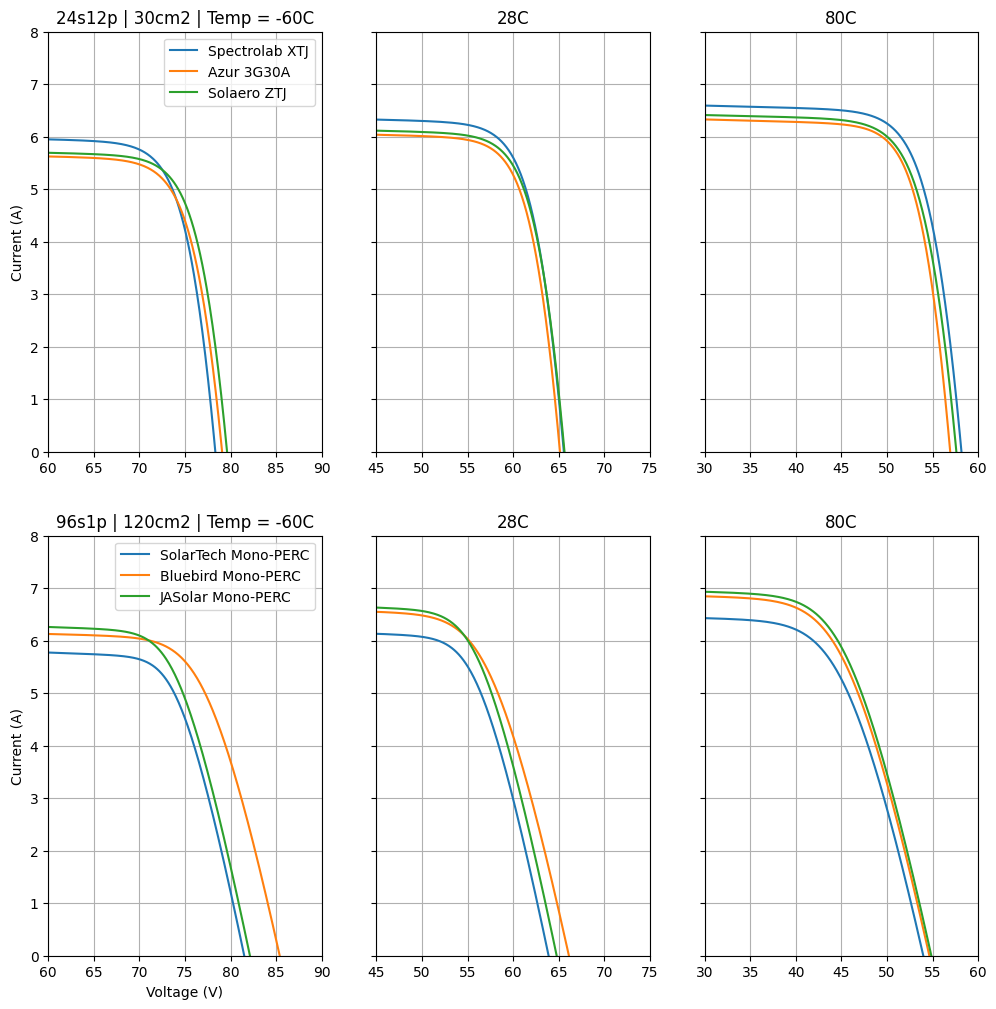

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 12))

for type in [spectrolab, azurspace, solaero]:
    for i, temp in enumerate([-60, 28, 80]):
        print("SOLVING:", type.name, temp)
        cell = celltype2solarcell(type, area=30).array(
            t=np.full((24, 12), temp), g=np.ones((24, 12))
        )
        v = np.linspace(0, cell.voc, 1000)
        ax[0, i].plot(v, cell.iv(v))
        print()

ax[0, 0].set_title("24s12p | 30cm2 | Temp = -60C")
ax[0, 0].set_xlim([60, 90]), ax[0, 0].grid()
ax[0, 1].set_xlim([45, 75]), ax[0, 1].grid(), ax[0, 1].set_title("28C")
ax[0, 2].set_xlim([30, 60]), ax[0, 2].grid(), ax[0, 2].set_title("80C")
ax[0, 0].legend(["Spectrolab XTJ", "Azur 3G30A", "Solaero ZTJ"])
ax[0, 0].set_ylabel("Current (A)")

for type in [solartech, bluebird, jasolar]:
    for i, temp in enumerate([-60, 28, 80]):
        print("SOLVING:", type.name, temp)
        cell = celltype2solarcell(type, area=120).array(
            t=np.full((96, 1), temp), g=np.ones((96, 1))
        )
        v = np.linspace(0, cell.voc, 1000)
        ax[1, i].plot(v, cell.iv(v))
        print()

ax[1, 0].set_title("96s1p | 120cm2 | Temp = -60C")
ax[1, 0].set_xlim([60, 90]), ax[1, 0].grid()
ax[1, 1].set_xlim([45, 75]), ax[1, 1].grid(), ax[1, 1].set_title("28C")
ax[1, 2].set_xlim([30, 60]), ax[1, 2].grid(), ax[1, 2].set_title("80C")
ax[1, 0].legend(["SolarTech Mono-PERC", "Bluebird Mono-PERC", "JASolar Mono-PERC"])
ax[1, 0].set_ylabel("Current (A)")
ax[1, 0].set_xlabel("Voltage (V)")

plt.ylim([0, 8])
plt.show()